# 주식 가격 예측 모델 개발

In [53]:
import gc
import os
import sys

from datetime import datetime
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import yfinance as yf


from tqdm import tqdm

In [2]:
data_path = Path.cwd().parent / "data"
stock_data_path = data_path / "stock_data/daily_stock_data"
image_file_path = data_path / "stock_chart_image"

## 데이터 수집 & 정제

### 코스피 시총 상위 주식 데이터 불러오기 & 저장

In [3]:
stock_code_dict = {
    "005930": "삼성",
    "000660": "SK하이닉스",
    "035420": "NAVER",
    "005380": "현대차",
    "035720": "카카오",
    "051910": "LG화학",
    "105560": "KB금융",
    "005490": "POSCO홀딩스",
    "055550": "신한지주",
    "003550": "LG"
}

In [4]:
yf.pdr_override()

for stock_code, name in tqdm(stock_code_dict.items()):
    stock_df = pdr.get_data_yahoo(f"{stock_code}.KS", "2012-05-01", "2022-05-01")
    
    #인덱스에 할당된 날짜 데이터를 컬럼으로 이동
    stock_df.reset_index(inplace=True)
    
    #이동평균선 생성을 위한 데이터 생성
    stock_df["ma_5"] = stock_df["Close"].rolling(5, 1).mean()
    stock_df["ma_20"] = stock_df["Close"].rolling(20, 1).mean()
    stock_df["ma_60"] = stock_df["Close"].rolling(60, 1).mean()
    # stock_df["ma_120"] = stock_df["Close"].rolling(120, 1).mean()
    # stock_df["ma_240"] = stock_df["Close"].rolling(240, 1).mean()
    
    #csv파일로 저장
    stock_df.to_csv(stock_data_path / f"{name}_{stock_code}.csv", index=False, encoding="utf-8")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.22s/it]


### 주식 차트 이미지 생성

- 각 차트 이미지 별로 20일치 거래 데이터를 포함한다.
- 해당 이미지의 마지막 일자를 기준으로 5일 뒤 가격을 보고 레이블링한다.
    - 5% 초과 하락 -> 하락 (1)
    - 5% 초과 상승 -> 상승 (2)
    - 가격변화의 절댓값이 5% 이하 -> 보합 (0)

In [4]:
def label_data(df:pd.DataFrame, 
               row_num: int,
               days: int,
               percentage: float):
    if df["Close"][row_num] * (1 - percentage) >= df["Close"][row_num + 5]:
        # Consider as decrease in price
        return 1
    elif df["Close"][row_num] * (1 + percentage) <= df["Close"][row_num + 5]:
        # Consider as increase in price
        return 2
    else:
        # Consider as no change in price
        return 0

In [31]:
def save_chart_image(df:pd.DataFrame, 
                     save_path: Path,
                     file_prefix: str,
                     window=20):
    customstyle = mpf.make_mpf_style(base_mpf_style='yahoo', facecolor='w')

    width_config={"candle_linewidth":1.5, 
                  "candle_width":0.9, 
                  "volume_width": 0.6, 
                  "line_width": 1}
                     
    for i in tqdm(range(len(df) - window - 5), desc=f"Data {file_prefix}"):
        target_df = df[i: i + window]
        label = label_data(df, i + window - 1, 5, 0.04)
        
        ma_5 = mpf.make_addplot(target_df.ma_5)
        ma_20 = mpf.make_addplot(target_df.ma_20)
        ma_60 = mpf.make_addplot(target_df.ma_60)
        # ma_120 = mpf.make_addplot(target_df.ma_120)
        # ma_240 = mpf.make_addplot(target_df.ma_240)
        
        file_path = save_path / f"{file_prefix}_{i}_{label}.jpg"

        fig, axlist = mpf.plot(target_df, 
                               type="candle",
                               style=customstyle, 
                               addplot=[ma_5, ma_20, ma_60],
                               update_width_config=width_config, 
                               figsize=(10, 10),
                               fontscale=0,
                               axisoff=True,
                               volume=True,
                               tight_layout=True,
                               returnfig=True,
                               closefig=True)
        fig.savefig(file_path)
        del(fig, axlist)

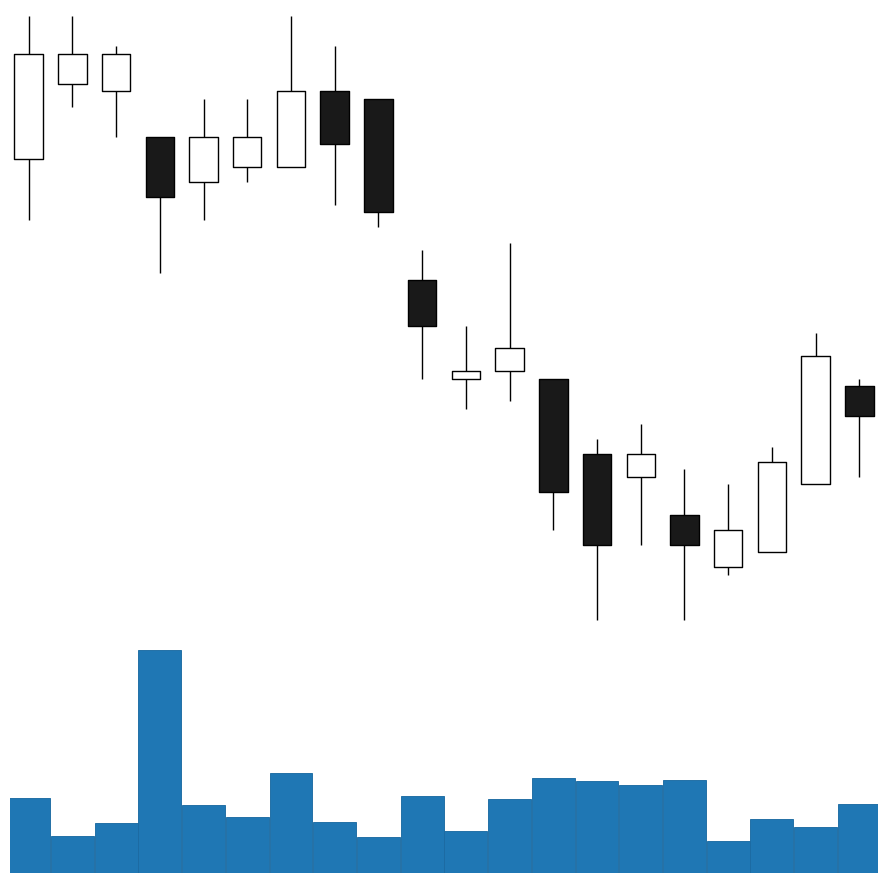

In [ ]:
fig, axlist = mpf.plot(stock_df[:20], 
                       type="candle",
                               figsize=(10, 10),
                               fontscale=0,
                               axisoff=True,
                               volume=True,
                               tight_layout=True,
                               returnfig=True,
                               closefig=True)
fig

In [ ]:
gc.collect()

23604215

In [57]:
matplotlib.use("agg")
for stock_code, name in stock_code_dict.items():
    if stock_code in list(stock_code_dict.keys())[:9]:
        continue
    stock_df = pd.read_csv(stock_data_path / f"{name}_{stock_code}.csv", encoding="utf-8")
    stock_df["Date"] = stock_df["Date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
    stock_df.set_index("Date", inplace=True, drop=True)
        
    if not os.path.isdir(image_file_path):
        os.mkdir(image_file_path)
    
    save_chart_image(stock_df, image_file_path, f"{name}_{stock_code}", 20)

Data 삼성_005930:  50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 1206/2434 [02:01<02:03,  9.92it/s]


KeyboardInterrupt: 

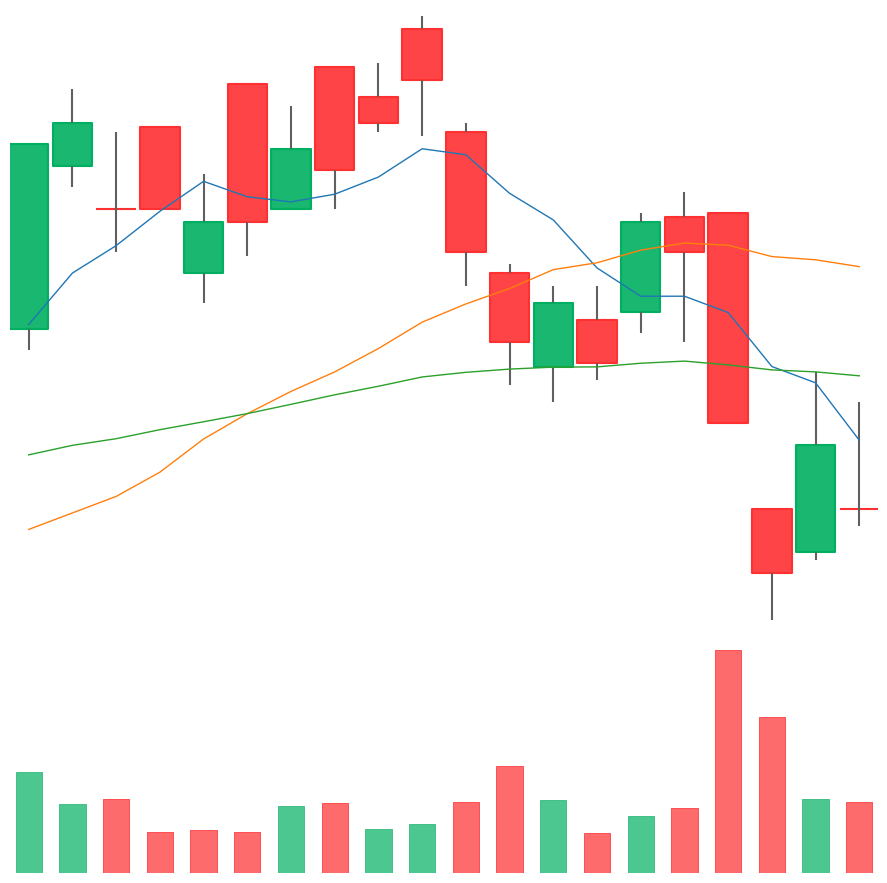

In [67]:
customstyle = mpf.make_mpf_style(base_mpf_style='yahoo', facecolor='w')

width_config={"candle_linewidth":1.5, 
              "candle_width":0.9, 
              "volume_width": 0.6, 
              "line_width": 1}

target_df = stock_df[200: 220]

ma_5 = mpf.make_addplot(target_df.ma_5, width=1)
ma_20 = mpf.make_addplot(target_df.ma_20, width=1)
ma_60 = mpf.make_addplot(target_df.ma_60, width=1)

mpf.plot(target_df, type="candle",
         style=customstyle, 
         addplot=[ma_5, ma_20, ma_60],
         update_width_config=width_config, 
         figsize=(10, 10),
         fontscale=0,
         axisoff=True,
         volume=True,
         tight_layout=True)

In [8]:
# for data in os.listdir(stock_data_path)[:10]:
#     stock_df = pd.read_csv(stock_data_path / data, encoding="utf-8")
#     stock_df = stock_df[stock_df.columns[1:]]
#     stock_df.rename(columns={"date": "Date", 
#                              "open": "Open", 
#                              "high": "High", 
#                              "low": "Low", 
#                              "close": "Close", 
#                              "volume": "Volume"},
#                     inplace=True)
#     stock_df["Date"] = stock_df["Date"].apply(lambda x: datetime.strptime(str(x), "%Y%m%d"))
#     stock_df.set_index("Date", inplace=True, drop=True)
    
#     file_prefix = data.split(".")[0]
    
#     if not os.path.isdir(image_file_path):
#         os.mkdir(image_file_path)
    
#     save_chart_image(stock_df, image_file_path, file_prefix)

Data A004440:   1%|██▌                                                                                                                                                                                                                                                                | 14/1447 [00:02<03:38,  6.55it/s]


KeyboardInterrupt: 

<Figure size 700x700 with 0 Axes>